SETUP

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin")   # Run only if necessary

from src.data.Dataset import Dataset as DS
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Check if GPU is available

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

DATASET

In [5]:
# Dataset generator

n = 10
m = 5
hop = 1/1200
input_dim   = 30 * n
pred_dim    = 30 * m + 0.25
shift       = pred_dim + 0.25
batch_size  = 16
Data        = DS(
                input_dim, 
                pred_dim, 
                shift, 
                skip=0.25, 
                hop=hop, 
                batch_size=batch_size,
                in_cols=['roll','heave','pitch','wave'],
                out_cols=['roll','wave']
            
                )

In [ ]:
def trans_data(data):
    inp1 = data.map(lambda x, y: x)
    inp2 = data.map(lambda x, y: y[:, 0:, -1])
    out = data.map(lambda x, y: y[:, :, 0])

    trans_data_ = tf.data.Dataset.zip(((inp1, inp2),out))
    return trans_data_

def teacher_forcing_data(data):
    inp1 = data.map(lambda x, y: x)
    inp2 = data.map(lambda x, y: tf.concat([tf.expand_dims(y[:,:-1,0], axis=-1), tf.expand_dims(y[:,1:,1], axis=-1)], axis=-1))
    out = data.map(lambda x, y: tf.expand_dims(y[:,1:,0], axis=-1))
    
    trans_data_ = tf.data.Dataset.zip(((inp1, inp2),out))
    return trans_data_

def trans_dataset(func, Data):
    train = func(Data.Train)
    val = func(Data.Val)
    test = func(Data.Test)
    return train, val, test

In [ ]:
Train, Val, Test = trans_dataset(teacher_forcing_data, Data)

In [ ]:
Train.element_spec

In [8]:
INPUT_DIM = Data.xshape
OUTPUT_DIM = Data.yshape

# print('Input dim:', INPUT_DIM)
# print('Output dim:', OUTPUT_DIM)

MODEL

In [16]:
# Loss functions

# Regression loss
MSE_loss = tf.keras.losses.MeanSquaredError()
MAE_loss = tf.keras.losses.MeanAbsoluteError()

# Metrics

# Regression metrics
MAPE = tf.keras.metrics.MeanAbsolutePercentageError()
MAE = tf.keras.metrics.MeanAbsoluteError()

In [10]:
# norm = tf.keras.layers.Normalization(input_shape=INPUT_DIM, axis=-1)
# x_ds = Data.Train.map(lambda x, y: x)
# norm.adapt(x_ds)

In [23]:
# Define model here

class EncDec(tf.keras.Model):
    def __init__(self, enc_units, dec_units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.enc_units = enc_units
        self.dec_units = dec_units
        
        enc_inp = tf.keras.Input()
        dec_inp = tf.keras.Input()

        # Encoder cells
        self.encoder_cells = [tf.keras.layers.LSTMCell(units) for units in self.enc_units]
        self.encoder_stacked = tf.keras.layers.StackedRNNCells(self.encoder_cells)
        self.encoder_rnn = tf.keras.layers.RNN(self.encoder_stacked, return_state=True)
#         self.enc_dense = tf.keras.layers.Dense(INPUT_DIM[-1])

        # Decoder cells
        self.decoder_cells = [tf.keras.layers.LSTMCell(units) for units in self.dec_units]
        self.dense = tf.keras.layers.Dense(1)

    def warmup(self, inputs):
        
        out = self.encoder_rnn(inputs)
#         x = self.enc_dense(out[0])
        x = inputs[:,-1:,0]
        
        return x, out[1:]

    def call(self, inputs, training=True):
        
        predictions = []
        
        prediction, states = self.warmup(inputs[0])

        # Insert the first prediction.
#         predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(0, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            inter = tf.concat([x, inputs[-1]], axis=-1)
            states_ = []
            
            for i in range(0, len(self.decoder_cells)):
                
                x, state = self.decoder_cells[i](inter, states=states[i],
                                        training=training)
                states_.append(state)                        
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)
            states = states_

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [ ]:
enc = [256]
dec = [256]
model = EncDec(enc, dec, OUTPUT_DIM[0])

In [24]:
# Compile model
LOSS = MSE_loss
METRICS = [MAPE, MAE]
LR = 1e-3

opt = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=opt, loss=LOSS, metrics=METRICS)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1200, 1024)        4210688   
                                                                 
 lstm_7 (LSTM)               (None, 128)               590336    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,801,153
Trainable params: 4,801,153
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Check if model is working and the output shape

for x, y in Train.take(1):
    out = model(x)
    print(out.shape)

(16, 1)


TRAINING

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=15,
                                                    mode='min')

checkpoint_filepath = 'models/EncDec_TF/03/model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="models/EncDec_TF/03/metrics", update_freq=50)

In [ ]:
# Model training

model.fit(Data.Train, epochs=100, validation_data=Data.Val, callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback])

In [ ]:
# Save model
# Uncomment to save model

# model_save_dir = 'models/EncDec_TF/03/model'

# model.save(model_save_dir)

IMPORTING SAVED MODEL

In [ ]:
# Load model

model_dir = 'models/EncDec_TF/03/model'

model = tf.keras.models.load_model(model_dir)

model.summary()

MODEL PERFORMANCE

In [ ]:
# Evaluate model

val_performance = model.evaluate(Data.Val)
test_performance = model.evaluate(Data.Test)

print('Validation MSE_loss: {:.2f}'.format(val_performance[0]))
print('Validation MAPE:     {:.2f}'.format(val_performance[1]))
print('Validation MAE:      {:.2f}'.format(val_performance[2]))
print('Test MSE_loss:       {:.2f}'.format(test_performance[0]))
print('Test MAPE:           {:.2f}'.format(test_performance[1]))
print('Test MAE:            {:.2f}'.format(test_performance[2]))

INFERENCE

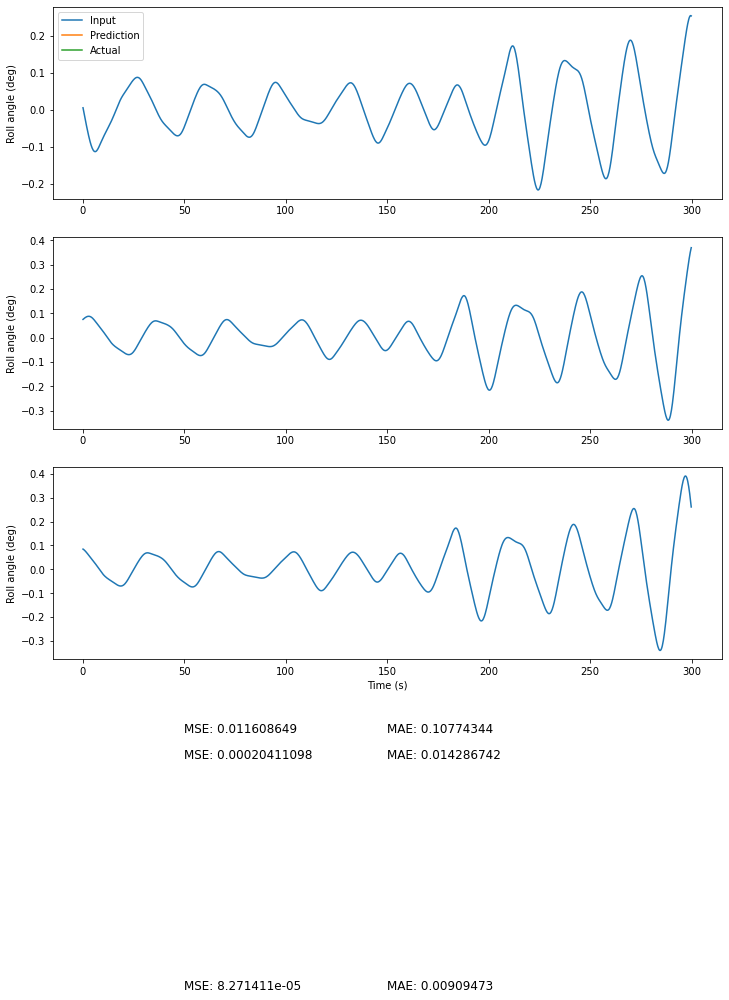

In [28]:
Data.plot_example(50, model)

In [15]:
MAX_EPOCHS = 20

def lr_optimizer(model, window, patience=2):

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-7 * 10**(epoch / 4))

  model.compile(loss=MSE_loss,
                optimizer=tf.optimizers.Adam(),
                metrics=[MAPE, MAE])

  history = model.fit(window.Train, epochs=MAX_EPOCHS,
                      validation_data=window.Val,
                      callbacks=[lr_scheduler])
  return history

In [16]:
history = lr_optimizer(oneshot_rnn_model, data)

Epoch 1/20
2738/2738 [==============================] - 105s 38ms/step - loss: 15.2822 - mean_absolute_percentage_error: 148.3496 - mean_absolute_error: 1.9759 - val_loss: 8.8733 - val_mean_absolute_percentage_error: 126.5278 - val_mean_absolute_error: 1.5410 - lr: 1.0000e-07
Epoch 2/20
2170/2738 [======================>.......] - ETA: 20s - loss: 19.1159 - mean_absolute_percentage_error: 156.3536 - mean_absolute_error: 2.3853

(1e-05, 0.001, 0.0, 20.0)

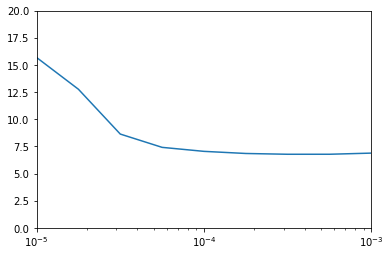

In [ ]:
lrs = 1e-5 * (10 ** (np.arange(MAX_EPOCHS) / 4))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-5, 1e-3, 0, 20])